In [169]:
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import os
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [170]:
def generate_map(num_nodes=20, grid_size=5, max_weight=10, seed=20):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    nodes = [chr(65 + i) for i in range(min(num_nodes, 26))]
    
    positions = {}
    for node in nodes:
        positions[node] = (
            random.uniform(0, grid_size-1),
            random.uniform(0, grid_size-1)
        )
    
    graph = {node: {} for node in nodes}
    edges = []
    weights = []
    
    for node1 in nodes:
        distances = []
        for node2 in nodes:
            if node1 != node2:
                dist = np.sqrt(
                    (positions[node1][0] - positions[node2][0])**2 +
                    (positions[node1][1] - positions[node2][1])**2
                )
                distances.append((dist, node2))
        
        n_connections = random.randint(2, 5)
        nearest = sorted(distances)[:n_connections]
        
        for dist, node2 in nearest:
            if node2 not in graph[node1]:
                weight = max(1, int(dist * 2))
                graph[node1][node2] = weight
                graph[node2][node1] = weight
                i = nodes.index(node1)
                j = nodes.index(node2)
                edges.append((i, j))
                weights.append(weight)
    
    nodes_tensor = torch.tensor([ord(n) for n in nodes])
    edges_tensor = torch.tensor(edges, dtype=torch.long)
    weights_tensor = torch.tensor(weights, dtype=torch.float)    
    positions_tensor = torch.zeros((len(nodes), 2), dtype=torch.float)
    for i, node in enumerate(nodes):
        positions_tensor[i] = torch.tensor(positions[node])
    
    return {
        'nodes': nodes,
        'nodes_tensor': nodes_tensor,
        'edges_tensor': edges_tensor,
        'weights_tensor': weights_tensor,
        'positions': positions,
        'positions_tensor': positions_tensor,
        'graph': graph
    }

In [171]:
os.makedirs('maps', exist_ok=True)
city_names = ['Mumbai', 'Guwahati', 'Delhi', 'Lucknow', 'Bangalore']
num_cities= len(city_names)
seed = 20 
for i in range(num_cities):
    seed=seed*random.randint(2,10)
    city_data = generate_map(seed = seed)
    city_data['name'] = city_names[i]
    torch.save(city_data, f'maps/{city_data["name"]}.pt')
    print(f"Generated and saved {city_data['name']}")

Generated and saved Mumbai
Generated and saved Guwahati
Generated and saved Delhi
Generated and saved Lucknow
Generated and saved Bangalore


In [172]:
cities = [f[:-3] for f in os.listdir('maps') if f.endswith('.pt')]
print("\nAvailable cities:")
for i, city in enumerate(cities):
    print(f"{i+1}. {city}")


Available cities:
1. Bangalore
2. Delhi
3. Guwahati
4. Lucknow
5. Mumbai


In [173]:
city_idx = input(f"Select a city (1-{len(cities)}, default 1): ")
city_idx = int(city_idx) - 1
city_name = cities[city_idx]
city_data = torch.load(f'maps/{city_name}.pt')

C:\Users\Arjun\AppData\Local\Temp\ipykernel_10316\2778032618.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  city_data = torch.load(f'maps/{city_name}.pt')


In [174]:
print(f"\nLoaded {city_name}")
print("Available nodes:", ", ".join(city_data['nodes']))

start = input(f"Enter start node (default '{city_data['nodes'][0]}'): ").upper() or city_data['nodes'][0]
goal = input(f"Enter goal node (default '{city_data['nodes'][-1]}'): ").upper() or city_data['nodes'][-1]

graph = city_data['graph']
positions = city_data['positions']


Loaded Bangalore
Available nodes: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T


In [175]:
def verify_heuristic_consistency(graph, heuristic):
    inconsistencies = []
    for node in graph:
        for neighbor, cost in graph[node].items():
            if heuristic[node] > heuristic[neighbor] + cost:
                inconsistencies.append({
                    'node': node,
                    'neighbor': neighbor,
                    'h_node': heuristic[node],
                    'h_neighbor': heuristic[neighbor],
                    'cost': cost,
                    'difference': heuristic[node] - (heuristic[neighbor] + cost)
                })
    is_consistent = len(inconsistencies) == 0
    return is_consistent, inconsistencies
def calculate_heuristic(positions, goal, scale_factor=1.0):
    heuristic = {}
    goal_pos = positions[goal]
    for node, pos in positions.items():
        dist = np.sqrt((pos[0] - goal_pos[0])**2 + (pos[1] - goal_pos[1])**2)
        heuristic[node] = dist * scale_factor
    
    return heuristic
def ensure_consistent_heuristic(graph, positions, goal, max_attempts=10):
    scale_factor = 1.0
    attempt = 1
    while attempt <= max_attempts:
        heuristic = calculate_heuristic(positions, goal, scale_factor)
        is_consistent, inconsistencies = verify_heuristic_consistency(graph, heuristic)
        if is_consistent:
            print(f"Found consistent heuristic on attempt {attempt} with scale factor {scale_factor:.3f}")
            return heuristic
        scale_factor *= 0.5
        attempt += 1
    
    print("Could not find consistent heuristic. Using last attempt.")
    return heuristic

In [176]:
heuristic = ensure_consistent_heuristic(graph, positions, goal)
is_consistent, inconsistencies = verify_heuristic_consistency(graph, heuristic)
open_set = []  
counter = 0
heapq.heappush(open_set, (heuristic[start], counter, start))
came_from = {}  
g_score = {node: float('inf') for node in graph}
g_score[start] = 0
f_score = {node: float('inf') for node in graph}
f_score[start] = heuristic[start]
open_set_hash = {start}
explored = []
node_scores = {}
iterations = 0

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

Found consistent heuristic on attempt 1 with scale factor 1.000


In [177]:
while open_set:
    iterations += 1
    current_f, _, current = heapq.heappop(open_set)
    open_set_hash.remove(current)
    explored.append(current)
    node_scores[iterations] = dict(f_score)
    
    if current == goal:
        path = reconstruct_path(came_from, current)
    
    for neighbor, weight in graph[current].items():
        tentative_g_score = g_score[current] + weight
        if tentative_g_score < g_score[neighbor]:
            came_from[neighbor] = current
            g_score[neighbor] = tentative_g_score
            f_score[neighbor] = g_score[neighbor] + heuristic[neighbor]
            if neighbor not in open_set_hash:
                counter += 1
                heapq.heappush(open_set, (f_score[neighbor], counter, neighbor))
                open_set_hash.add(neighbor)

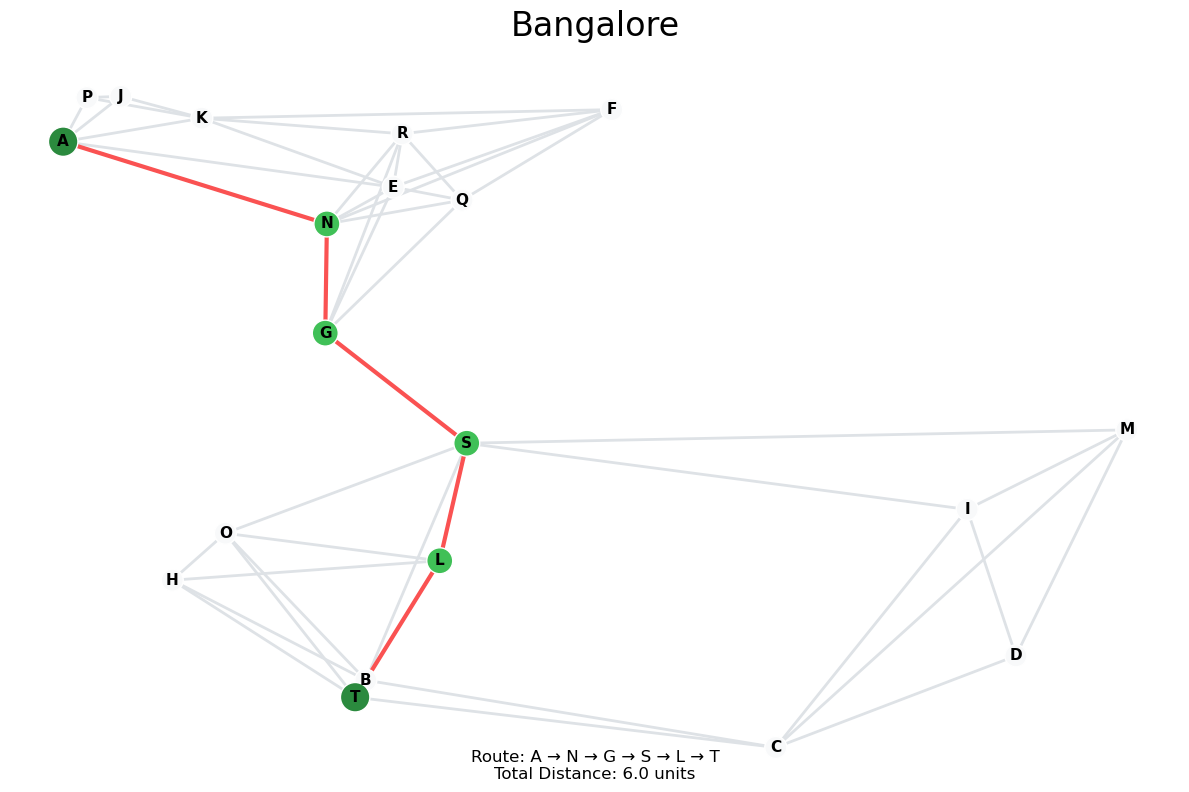

In [178]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.set_axis_off()
G = nx.Graph(graph)
edges = [(positions[u], positions[v]) for u, v in G.edges()]
path_edges = []
if path:
    path_edges = [(positions[path[i]], positions[path[i+1]]) 
                    for i in range(len(path)-1)]
ax.add_collection(LineCollection(edges, colors='#DEE2E6', linewidths=2))
if path_edges:
    ax.add_collection(LineCollection(path_edges, colors='#FA5252', linewidths=3))
node_colors = ['#F8F9FA'] * len(G)  
node_sizes = [250] * len(G)        

if path:
    for i, node in enumerate(G.nodes()):
        if node in path:
            node_colors[i] = '#40C057'
            node_sizes[i] = 350
        if node in (start, goal):
            node_colors[i] = '#2B8A3E'
            node_sizes[i] = 450

nx.draw_networkx_nodes(G, positions, node_color=node_colors, 
                        node_size=node_sizes, edgecolors='#FFFFFF')
nx.draw_networkx_labels(G, positions, font_size=11, font_weight='bold')
plt.title(city_name, fontsize=24, pad=20)
if path:
    cost = sum(graph[path[i]][path[i+1]] for i in range(len(path)-1))
    plt.figtext(0.5, 0.02, 
                f"Route: {' → '.join(path)}\nTotal Distance: {cost:.1f} units",
                ha="center", fontsize=12)

plt.tight_layout()